In [1]:
from fastai.imports import *
import seaborn as sns
import graphviz
from pickle import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Dataset Preparation

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
df.head()

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,...,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,...,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,...,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,...,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0


In [3]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
# dep="MINIdepression"
# dep="Panxiety"
dep="PPTSD"
for label in cats:
    df[label] = pd.Categorical(df[label])

In [120]:
df[dep].value_counts()

PPTSD
1    61
0    30
Name: count, dtype: int64

## Save all plot in figures

In [4]:
df_is_depress = df[(df[dep] == 1)]
df_is_depress.Age.describe()

count    61.000000
mean     17.327869
std       4.972328
min      12.000000
25%      15.000000
50%      16.000000
75%      18.000000
max      39.000000
Name: Age, dtype: float64

In [5]:
df_isnot_depress = df[(df[dep] == 0)]
df_isnot_depress.Age.describe()

count    30.000000
mean     19.833333
std       7.891870
min      13.000000
25%      16.250000
50%      17.000000
75%      19.750000
max      54.000000
Name: Age, dtype: float64

## Split Dataset

In [6]:
trn_df,val_df = train_test_split(df, test_size=0.25)

In [7]:
trn_df[dep].value_counts()

PPTSD
1    47
0    21
Name: count, dtype: int64

In [8]:
val_df[dep].value_counts()

PPTSD
1    14
0     9
Name: count, dtype: int64

> The distribution between the dependent variable seem ok.

In [20]:
trn_df[cats].describe()

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV
count,68,68,68,68,68,68,68,68,68,68,68,68,68,68
unique,2,2,2,3,2,2,2,3,2,2,2,2,2,2
top,1,1,1,3,1,1,0,0,1,1,1,0,1,1
freq,63,59,53,44,55,66,51,38,62,42,55,49,40,58


## Selecting Features

In [9]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [10]:
print(f'Training Shape: {trn_xs.shape}')
print(f'Validation Shape: {val_xs.shape}')

Training Shape: (68, 15)
Validation Shape: (23, 15)


> Bear in mind that the df is no longer categorical

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
trn_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
50,0,0,0,2,1,1,0,0,1,1,1,0,1,1,17
22,1,0,0,1,0,1,1,1,1,1,1,0,0,1,12
21,1,1,1,1,1,1,1,0,1,1,1,0,0,1,14
72,1,1,0,1,1,1,1,0,1,1,1,1,1,1,14
84,1,1,0,1,1,0,0,0,1,1,0,1,1,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1,1,1,1,1,1,0,2,1,1,1,0,1,1,18
70,1,1,1,2,1,1,0,2,1,1,1,0,1,1,16
53,1,1,1,2,1,1,0,0,1,0,1,0,0,1,16
66,1,1,1,1,1,1,0,0,1,0,1,0,1,1,19


In [13]:
trn_y

50    1
22    1
21    1
72    1
84    1
     ..
58    1
70    1
53    0
66    0
57    1
Name: PPTSD, Length: 68, dtype: int64

In [14]:
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
79,1,1,1,1,1,1,0,0,1,1,1,1,1,1,22
2,1,1,0,0,1,1,0,0,0,0,0,0,0,0,14
71,1,1,1,2,1,1,0,1,1,0,1,1,0,1,16
59,1,1,0,1,1,1,1,0,1,1,1,1,1,1,15
6,1,1,1,2,1,1,0,0,0,0,0,0,0,0,13
78,1,1,0,2,0,1,1,2,1,1,1,1,1,1,19
44,1,1,1,1,1,1,1,2,1,0,1,0,0,1,16
16,1,1,1,2,1,1,0,0,1,1,1,0,1,1,16
34,1,1,1,2,1,1,0,1,1,1,1,0,1,1,14
68,1,1,0,1,1,1,0,0,1,0,1,0,0,1,19


In [15]:
val_y

79    1
2     1
71    0
59    1
6     0
78    1
44    1
16    1
34    1
68    0
5     1
49    0
81    0
64    1
39    1
17    1
74    0
0     1
3     0
36    0
24    1
1     1
23    1
Name: PPTSD, dtype: int64

In [117]:
val_y.index

Index([74, 64, 75, 55, 60, 10, 32, 82, 86, 36, 43, 76, 59, 12, 49, 87, 35, 71,
       72, 66,  6, 58,  1],
      dtype='int64')

## Normalize Data

In [33]:
sc = StandardScaler()
trn_xs = pd.DataFrame(sc.fit_transform(trn_xs), columns = trn_xs.columns)
val_xs = pd.DataFrame(sc.fit_transform(val_xs), columns = val_xs.columns)
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
0,0.0,0.213201,-1.511858,-0.493197,0.527046,0.458831,-0.661438,0.794101,0.213201,0.957427,0.387298,-0.730297,0.877058,0.308607,-0.264403
1,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,-0.661438,-0.610847,0.213201,-1.044466,0.387298,-0.730297,-1.140175,0.308607,-0.132201
2,0.0,0.213201,-1.511858,1.397391,0.527046,0.458831,1.511858,0.794101,0.213201,-1.044466,0.387298,-0.730297,0.877058,0.308607,-0.528806
3,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,1.511858,-0.610847,0.213201,-1.044466,-2.581989,-0.730297,-1.140175,-3.240370,-0.661007
4,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,-0.661438,-0.610847,0.213201,-1.044466,0.387298,-0.730297,0.877058,0.308607,-0.264403
5,0.0,0.213201,-1.511858,1.397391,0.527046,0.458831,-0.661438,-0.610847,0.213201,0.957427,0.387298,-0.730297,0.877058,0.308607,0.000000
6,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,1.511858,-0.610847,0.213201,0.957427,0.387298,-0.730297,-1.140175,0.308607,-0.925410
7,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,-0.661438,-0.610847,0.213201,0.957427,0.387298,-0.730297,-1.140175,0.308607,-0.528806
8,0.0,0.213201,0.661438,-0.493197,0.527046,-2.179449,-0.661438,-0.610847,0.213201,0.957427,0.387298,1.369306,0.877058,0.308607,2.247423
9,0.0,0.213201,0.661438,-0.493197,0.527046,0.458831,-0.661438,-0.610847,0.213201,-1.044466,0.387298,-0.730297,-1.140175,0.308607,0.132201


# Logistic Regression

## Model Training and Prediction

In [11]:
logreg = LogisticRegression()
logreg.fit(trn_xs, trn_y)

LogisticRegression()

## Model Evaluation

### MAE For Validation Set

In [12]:
y_pred = logreg.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.30434782608695654

### MAE For Training Set

In [13]:
y_train_pred = logreg.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.23529411764705882

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

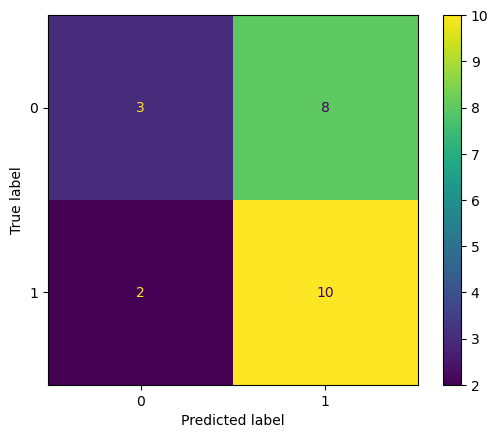

In [37]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not. If the purple boxes is more towards zero, the better it is since that means the model did never guessed wrong.

### Accuracy, Precision, Recall

In [38]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5652173913043478
Precision: 0.5555555555555556
Recall: 0.8333333333333334


Accuracy: In general, when the model makes prediction, it is right 57% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [39]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.60      0.27      0.38        11
   with PPTSD       0.56      0.83      0.67        12

     accuracy                           0.57        23
    macro avg       0.58      0.55      0.52        23
 weighted avg       0.58      0.57      0.53        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

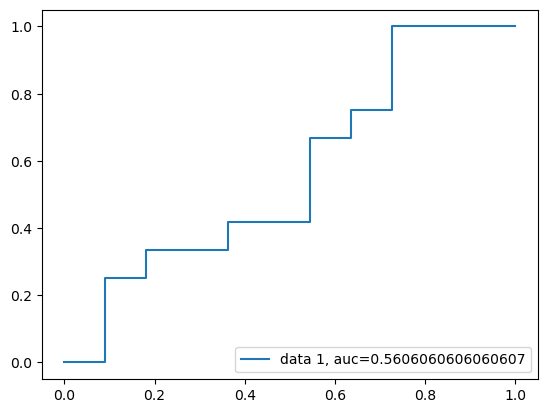

In [40]:
y_pred_proba = logreg.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.55. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.

### Feature Importance

#### By Training Set

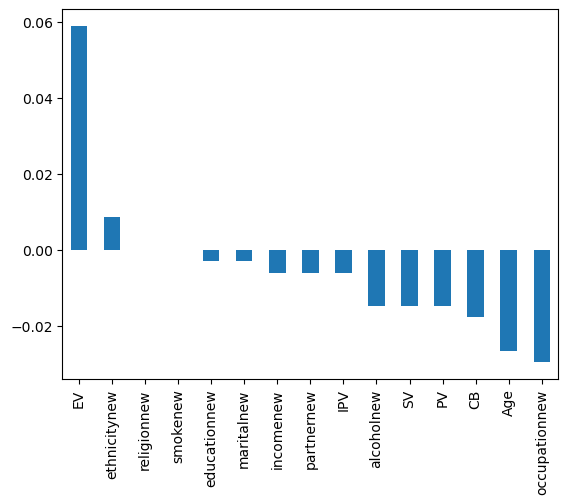

In [14]:
logreg_fi = permutation_importance(logreg, trn_xs, trn_y)
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(logreg_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.04 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

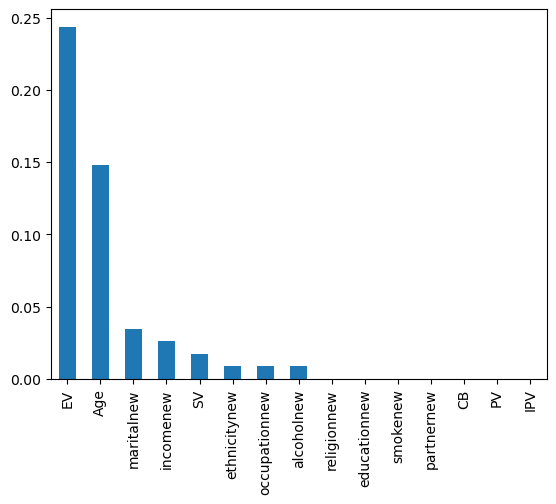

In [15]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

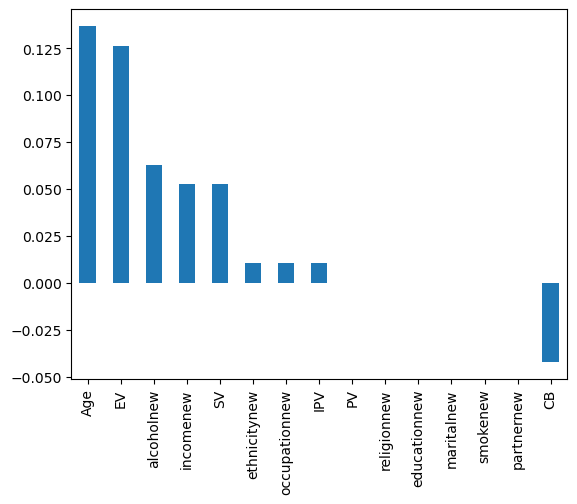

In [176]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

## Saving The Model

---

# Random Forest

## Model Training and Prediction

In [84]:
rf = RandomForestClassifier(100, min_samples_leaf=2)
rf.fit(trn_xs, trn_y)

RandomForestClassifier(min_samples_leaf=2)

## Model Evaluation

### MAE For Validation Set

In [85]:
y_pred = rf.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.2608695652173913

### MAE For Training Set

In [86]:
y_train_pred = rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.16176470588235295

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

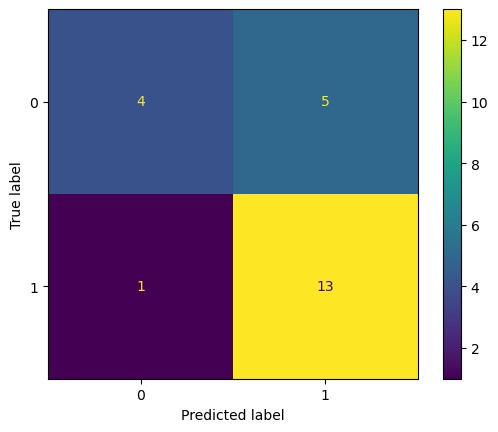

In [87]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [88]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7391304347826086
Precision: 0.7222222222222222
Recall: 0.9285714285714286


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [89]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.80      0.44      0.57         9
   with PPTSD       0.72      0.93      0.81        14

     accuracy                           0.74        23
    macro avg       0.76      0.69      0.69        23
 weighted avg       0.75      0.74      0.72        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

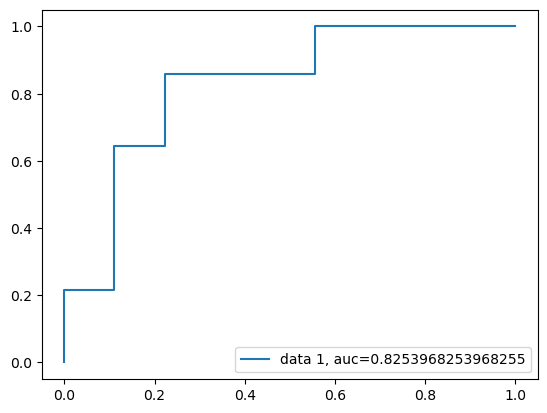

In [90]:
y_pred_proba = rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.56. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression

### Permutation Importance

#### By Training Set

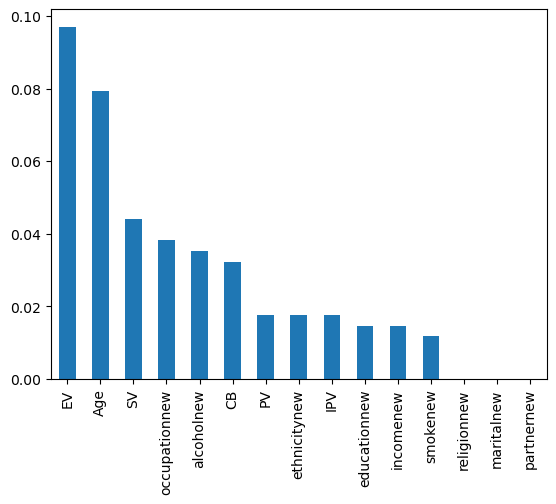

In [96]:
rf_fi = permutation_importance(rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.1 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

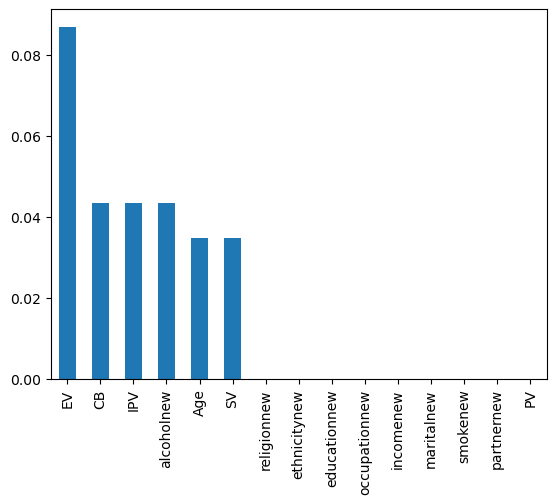

In [97]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

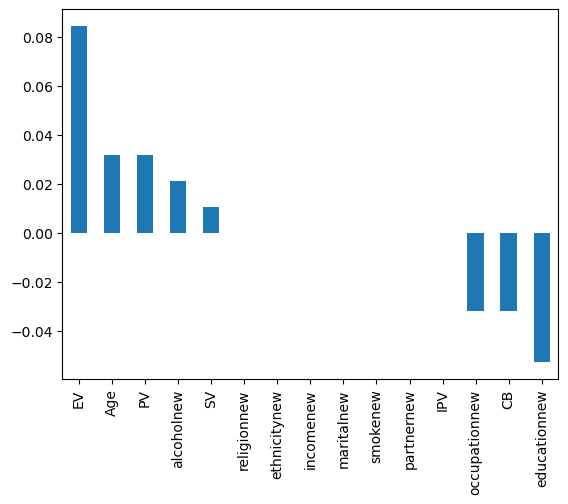

In [186]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

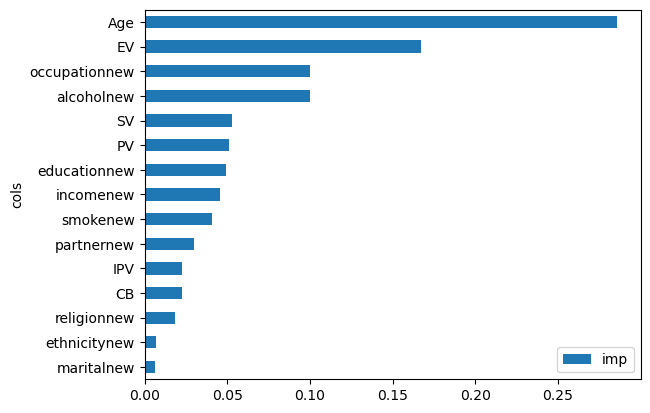

In [91]:
imp = rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### What Does Our Model See?

In [100]:
y_pred = rf.predict(val_xs)

In [101]:
y_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1], dtype=int64)

In [103]:
val_xs['target'] = y_pred

In [104]:
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age,target
84,1,1,0,1,1,0,0,0,1,1,0,1,1,1,31,1
80,1,1,1,0,1,1,0,1,1,1,1,1,1,1,21,1
69,1,1,1,1,1,1,0,0,1,0,1,0,0,1,22,0
65,1,1,0,1,1,1,0,1,1,1,1,0,1,1,19,1
25,1,1,1,0,1,1,1,0,1,1,1,1,1,1,17,1
53,1,1,1,2,1,1,0,0,1,0,1,0,0,1,16,1
77,1,1,0,2,0,1,1,2,1,1,1,0,1,1,22,1
71,1,1,1,2,1,1,0,1,1,0,1,1,0,1,16,1
5,1,1,1,2,0,1,0,0,0,0,0,0,0,0,15,1
17,1,1,1,2,1,1,0,0,1,0,1,0,1,1,16,1


In [105]:
trn_y_pred = rf.predict(trn_xs)
trn_xs['target'] = trn_y_pred

In [106]:
trn_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age,target
78,1,1,0,2,0,1,1,2,1,1,1,1,1,1,19,1
56,1,1,1,1,1,1,0,0,1,0,1,0,0,1,20,0
11,1,1,0,1,1,1,1,2,1,1,1,0,0,1,14,1
79,1,1,1,1,1,1,0,0,1,1,1,1,1,1,22,1
83,1,1,1,2,0,1,0,0,1,0,1,0,0,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1,1,1,2,1,1,0,0,1,1,1,0,0,1,15,1
28,1,1,1,2,1,1,0,0,1,1,1,0,0,1,17,1
74,1,1,1,1,0,1,0,2,1,1,1,1,1,1,18,1
48,1,1,1,0,0,1,0,2,1,1,1,0,1,1,17,1


In [108]:
predicted_df = pd.concat([trn_xs,val_xs])

[Text(0.5, 1.0, 'Histogram')]

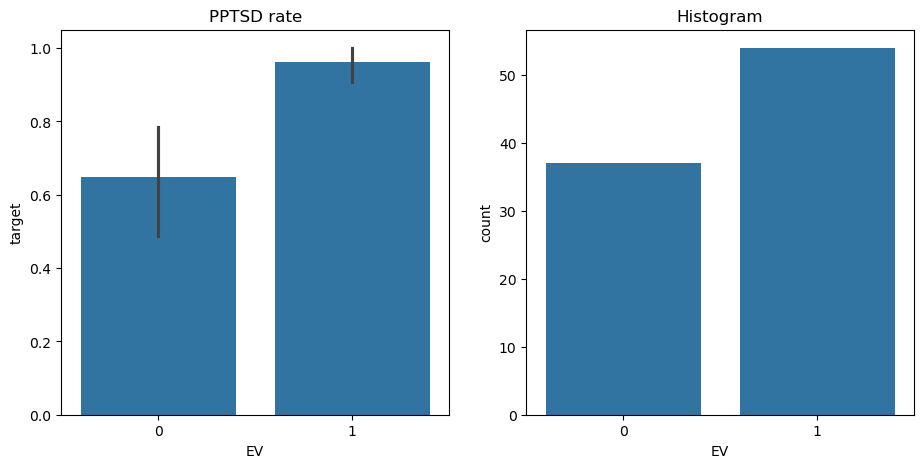

In [110]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=predicted_df, y='target', x='EV', ax=axs[0]).set(title=f"{dep} rate")
sns.countplot(data=predicted_df, x='EV', ax=axs[1]).set(title="Histogram")


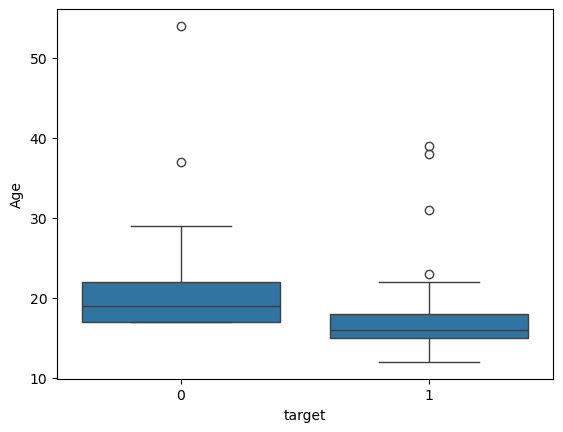

In [109]:
sns.boxplot(data=predicted_df, y='Age', x='target')
# plt.savefig(f'./figures/Age_box.png')
plt.show()

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

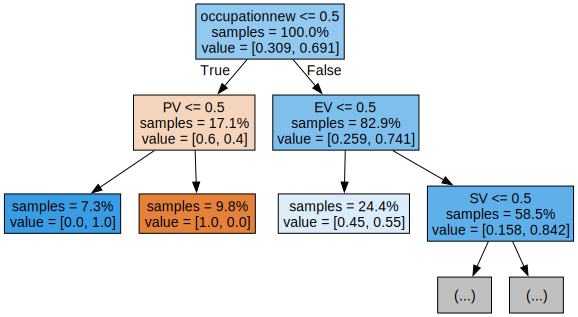

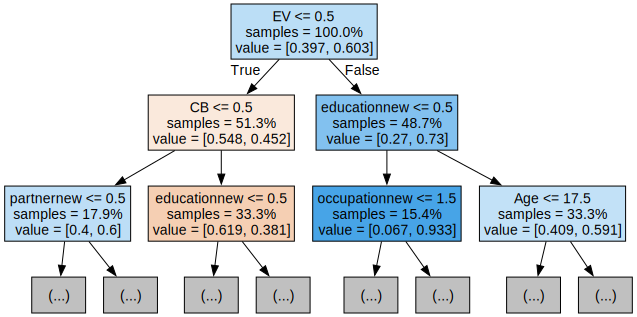

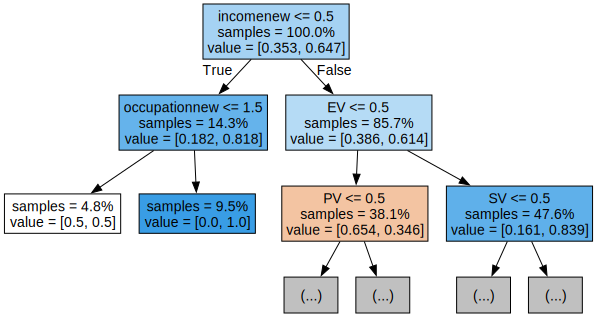

In [99]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Hyperparameter Tuning

In [410]:
randint(50,500)

In [188]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf2 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf2, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(trn_xs, trn_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027DA2AD2450>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027DA2D6A710>})

In [189]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(val_xs)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 92}


### Model Evaluation

#### MAE For Validation Set

In [190]:
mean_absolute_error(val_y, y_pred)

0.3157894736842105

### MAE For Training Set

In [191]:
y_train_pred = best_rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.013888888888888888

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

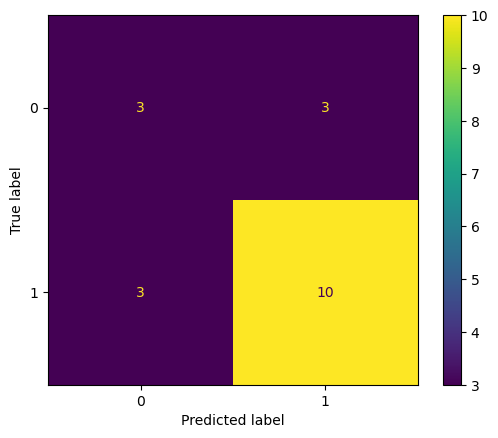

In [192]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is somewhat confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [193]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6842105263157895
Precision: 0.7692307692307693
Recall: 0.7692307692307693


### Classification Report

In [194]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.50      0.50      0.50         6
   with PPTSD       0.77      0.77      0.77        13

     accuracy                           0.68        19
    macro avg       0.63      0.63      0.63        19
 weighted avg       0.68      0.68      0.68        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

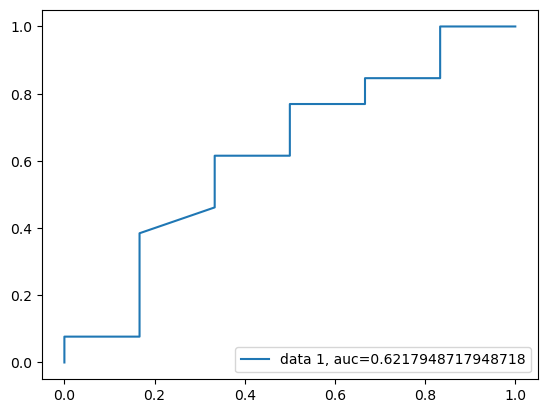

In [195]:
y_pred_proba = best_rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.53. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression?

### Permutation Importance

#### By Training Set

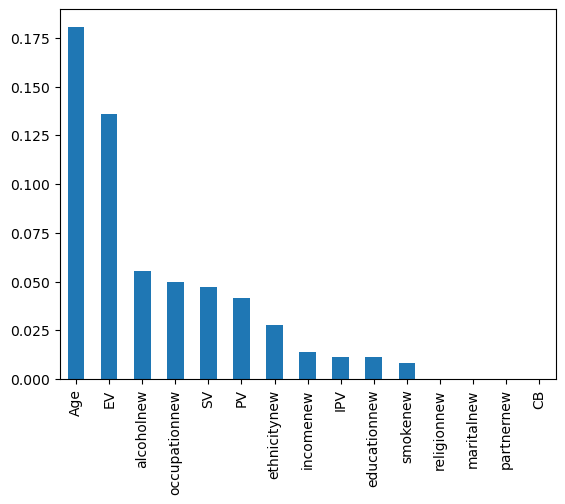

In [196]:
rf_pi = permutation_importance(best_rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_pi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.16 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

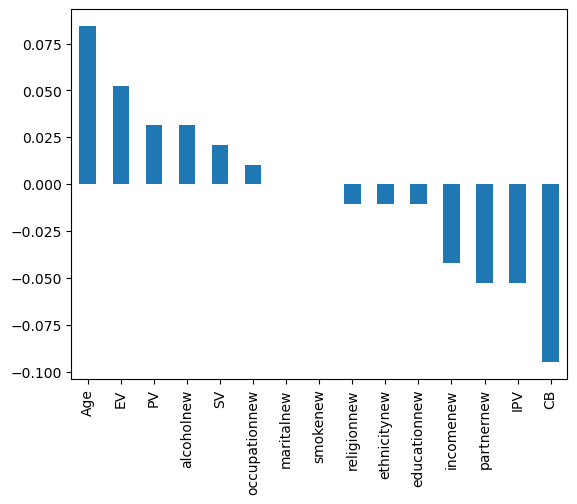

In [197]:
rf_pi_val = permutation_importance(best_rf, val_xs, val_y)

feature_importances = pd.Series(rf_pi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

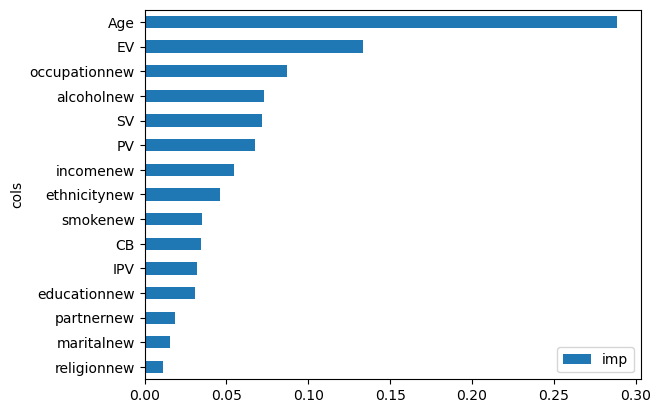

In [198]:
imp = best_rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

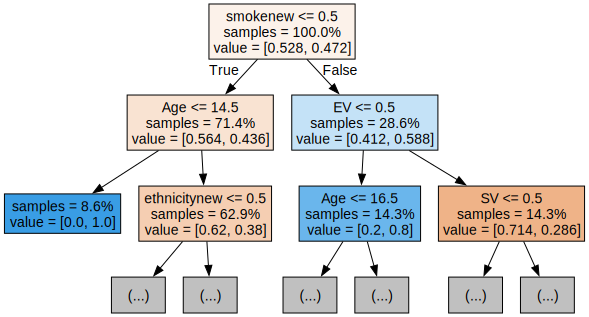

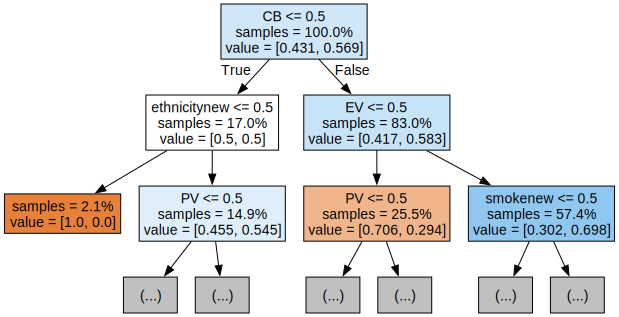

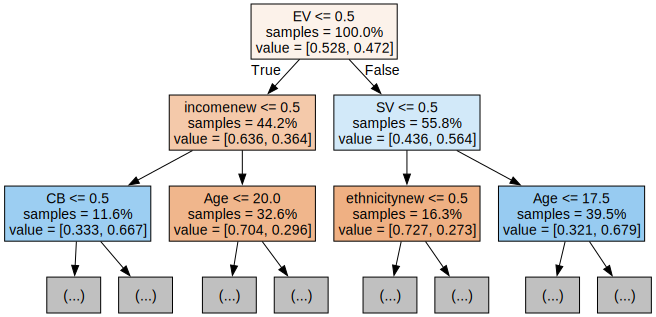

In [44]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Saving The Model

## Loading The Model

---

# Finding p-value

## Using OLS

In [92]:
sm_X, sm_Y = xs_y(df)

In [93]:
sm_X2 = sm.add_constant(sm_X)

In [94]:
est = sm.OLS(sm_Y, sm_X2)

In [95]:
est2 = est.fit()

In [96]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PPTSD   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.095
Date:                Fri, 19 Jul 2024   Prob (F-statistic):             0.0191
Time:                        16:35:22   Log-Likelihood:                -44.512
No. Observations:                  91   AIC:                             121.0
Df Residuals:                      75   BIC:                             161.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1836      0.728      3.000      0.004       0.734       3.634
religionnew      -0.0490      0.292     -0.168      0.867      -0.630       0.532
ethnicitynew     -0.1984      0.217     -0.915      0.363      -0.630       0.233
educationnew     -0.0224      0.119     -0.188      0.852      -0.260       0.215
occupationnew     0.0082      0.076      0.107      0.915      -0.144       0.160
incomenew        -0.1362      0.126     -1.077      0.285      -0.388       0.116
maritalnew       -0.6650      0.387     -1.718      0.090      -1.436       0.106
smokenew          0.0344      0.128      0.269      0.789      -0.221       0.289
alcoholnew        0.0511      0.063      0.807      0.422      -0.075       0.177
partnernew       -0.0353      0.266     -0.133      0.895      -0.565       0.494
EV                0.3614      0.123      2.947      0.004       0.117       0.606
CB                0.1302      0.245      0.532      0.597      -0.358       0.618
PV                0.0197      0.123      0.161      0.873      -0.225       0.264
SV                0.1678      0.118      1.418      0.160      -0.068       0.404
IPV              -0.4451      0.335     -1.330      0.187      -1.112       0.221
Age              -0.0337      0.016     -2.084      0.041      -0.066      -0.001
==============================================================================
Omnibus:                        6.506   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.197
Skew:                          -0.579   Prob(JB):                       0.0451
Kurtosis:                       2.460   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Using Logistic Regression

In [97]:
sm_X, sm_Y = xs_y(df)
a = dep + ' ~ '
for label in sm_X.columns:
    a += label + ' + '

formula = f'{dep} ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'
formula

'PPTSD ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'

In [115]:
smf_model = smf.logit(formula, data=df).fit(maxiter=200)

         Current function value: 0.459872
         Iterations: 200


C:\Users\shamy\miniconda3\envs\cenno\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
smf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  PPTSD   No. Observations:                   91
Model:                          Logit   Df Residuals:                       73
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Jul 2024   Pseudo R-squ.:                  0.2746
Time:                        16:38:49   Log-Likelihood:                -41.848
converged:                      False   LL-Null:                       -57.689
Covariance Type:            nonrobust   LLR p-value:                   0.01648
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             34.8803    2.2e+05      0.000      1.000   -4.31e+05    4.31e+05
religionnew[T.1]     -24.0686    2.2e+05     -0.000      1.000   -4.31e+05    4.31e+05
ethnicitynew[T.1]     -1.2476      1.412     -0.884      0.377      -4.015       1.519
educationnew[T.1]     -0.1243      0.780     -0.159      0.873      -1.653       1.404
occupationnew[T.2]     0.7405      0.970      0.763      0.445      -1.161       2.642
occupationnew[T.3]     0.2629      0.923      0.285      0.776      -1.546       2.072
incomenew[T.1]        -1.2485      0.850     -1.469      0.142      -2.915       0.418
maritalnew[T.1]       -4.4974      2.565     -1.753      0.080      -9.525       0.530
smokenew[T.1]          0.2166      0.762      0.284      0.776      -1.278       1.711
alcoholnew[T.1]        0.7305      0.926      0.789      0.430      -1.085       2.546
alcoholnew[T.2]        0.5831      0.818      0.713      0.476      -1.020       2.186
partnernew[T.1]       -0.0655      1.461     -0.045      0.964      -2.929       2.798
EV[T.1]                1.9401      0.696      2.787      0.005       0.576       3.305
CB[T.1]                0.6433      1.686      0.382      0.703      -2.661       3.948
PV[T.1]                0.1816      0.777      0.234      0.815      -1.342       1.705
SV[T.1]                0.9809      0.694      1.414      0.157      -0.379       2.341
IPV[T.1]              -2.3044      2.062     -1.118      0.264      -6.345       1.736
Age                   -0.2428      0.129     -1.876      0.061      -0.496       0.011
======================================================================================
"""

---

# FastAI Tabular Learner

## Model Training and Prediction

In [204]:
from fastai.tabular.all import *

In [205]:
splits = RandomSplitter()(df)

In [206]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [267]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.004365158267319202)

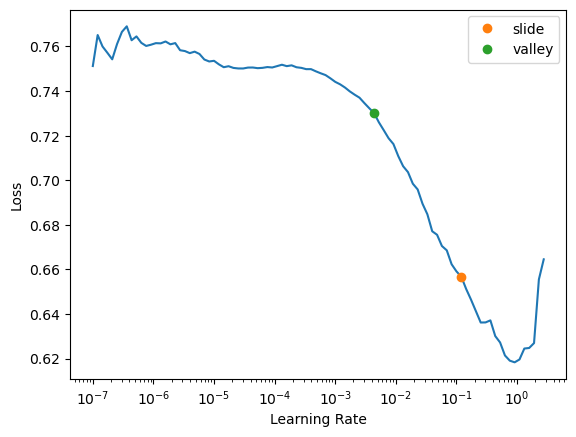

In [56]:
learn.lr_find(suggest_funcs=(slide, valley))

In [277]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.382878,0.712261,0.666667,00:00
1,0.380822,0.702041,0.666667,00:00
2,0.357151,0.683436,0.666667,00:00
3,0.354819,0.675838,0.666667,00:00
4,0.354418,0.666937,0.666667,00:00
5,0.351347,0.663284,0.666667,00:00
6,0.357469,0.665567,0.666667,00:00
7,0.360674,0.660427,0.666667,00:00
8,0.354892,0.653988,0.666667,00:00
9,0.354924,0.647646,0.666667,00:00


In [278]:
trn_split,val_split=splits

In [279]:
df.iloc[val_split]

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
16,32,1,16,1,1,2,4,1,1,3,2,7,2,17,2,4,5,5,2,2,2,1,1,1,1,4,1,2,1,2,1,1,1,1,2,1,2,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,1,3,4,4,4,4,5,2,,1,4,1,4,4,1,0,1,1,1,1,1,1,1,0,1,7,2,0,1,1,1,2,1,3,1,10,3,1,1,0,1,3,3,1,3,1,2,3,3,1,1,1,3,1,3,2,1,2,36,1,1,1,2,,2,1,1,2,1,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,0,1
22,24,1,12,1,4,1,1,2,1,1,1,6,1,18,2,1,1,1,1,2,2,1,1,1,1,4,2,2,2,2,2,2,1,1,1,2,3,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,1,2,,2,,1,1,1,2,2,2,2,2,2,2,1,1,16,4,0,3,1,3,3,3,3,3,19,4,1,4,1,4,4,4,4,4,4,4,4,4,0,4,4,4,2,2,2,4,4,67,1,1,1,2,,2,1,1,1,1,2,1,1,1,1,1,1,0,0,1,1,1,0,0,1,0,2,1,1,1
24,34,1,16,1,1,2,4,2,1,3,3,7,5,18,2,1,6,6,1,2,5,3,1,2,1,1,1,2,1,2,2,2,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,3,3,4,1,3,2,,2,,1,1,0,1,3,1,1,3,0,0,1,0,10,3,0,3,3,3,3,3,3,3,21,4,1,3,2,3,3,3,3,2,2,2,3,3,4,4,4,3,3,4,4,2,4,61,1,1,1,1,1,2,2,1,1,2,1,2,2,1,1,0,1,0,0,1,1,1,1,0,1,1,3,0,0,1
50,44,1,17,3,3,1,4,1,1,3,3,7,1,20,4,3,6,6,2,2,2,2,2,1,1,1,1,1,1,2,2,2,2,1,1,2,1,2,2,1,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,3,3,3,4,1,1,1,7,2,,1,3,2,3,1,2,3,3,1,1,3,1,19,4,0,2,2,1,3,2,3,2,15,4,1,4,3,2,4,1,3,1,3,4,4,4,4,3,4,1,3,2,1,3,1,55,1,1,1,2,,1,2,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,3,0,0,1
33,13,1,15,1,1,2,4,1,1,3,3,7,1,19,3,1,5,5,2,2,2,1,1,1,1,2,2,,1,2,1,1,1,1,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,3,3,4,1,10,1,7,2,,2,2,1,1,2,1,1,3,1,2,2,1,14,3,0,3,3,3,2,2,2,2,17,4,1,4,3,1,4,2,4,1,0,1,4,4,2,3,4,2,1,2,1,2,2,47,1,1,1,2,,2,2,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,3,0,0,1
18,2,1,17,1,1,2,4,1,1,2,2,7,2,18,3,1,6,6,1,3,2,2,1,3,1,2,2,1,1,2,1,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,1,1,2,,1,13,1,2,2,0,1,1,0,2,3,0,2,3,11,3,0,1,1,0,1,2,1,1,7,2,0,0,0,1,2,2,1,1,1,1,1,0,0,3,1,3,1,1,0,0,3,22,0,2,,1,2,2,2,2,2,2,1,1,1,2,0,1,1,0,0,1,1,1,1,1,1,1,3,1,0,1
3,15,1,15,1,1,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,34,1,13,1,13,4,2,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,,2,,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,1,1,1,1,1,3,0,0,0
39,60,1,14,1,1,2,4,1,1,3,2,6,1,19,2,1,6,1,2,3,5,1,1,1,1,2,2,1,1,2,1,1,1,1,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,3,4,4,4,4,5,2,,2,,1,3,1,1,0,3,0,3,1,3,3,0,3,3,16,4,0,2,3,3,3,3,0,3,17,4,1,3,4,3,4,4,4,3,4,4,4,4,2,4,4,4,0,4,0,4,1,64,1,1,1,2,,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,1,1
55,71,2,23,1,5,3,4,1,1,3,1,6,1,20,3,4,2,5,2,4,5,1,1,1,3,3,1,2,1,1,2,1,2,1,2,1,1,2,3,2,3,2,3,1,1,2,3,2,3,2,3,2,3,1,2,1,2,1,2,3,4,4,4,4,5,1,7,1,7,2,14,2,4,3,1,3,3,3,3,3,1,1,1,21,5,1,3,2,3,1,1,3,3,16,4,1,4,3,2,4,2,4,3,2,3,4,4,2,2,2,4,1,4,3,4,4,61,1,1,2,1,1,1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,0,1,1,0,3,0,1,1
56,74,2,20,1,1,2,1,1,1,

In [280]:
tst_dl = learn.dls.test_dl(df.iloc[val_split])

In [281]:
y_prob_ai, val_y_ai, y_pred_ai  = learn.get_preds(dl=tst_dl, with_decoded=True)

## Model Evaluation

### MAE For Validation Set

In [282]:
mean_absolute_error(val_y_ai, y_pred_ai)

0.3333333333333333

### MAE For Training Set

In [283]:
training_dl = learn.dls.test_dl(df.iloc[trn_split])
y_train_prob_ai, train_y_ai, y_train_pred_ai  = learn.get_preds(dl=training_dl, with_decoded=True)
mean_absolute_error(train_y_ai, y_train_pred_ai)

0.0684931506849315

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

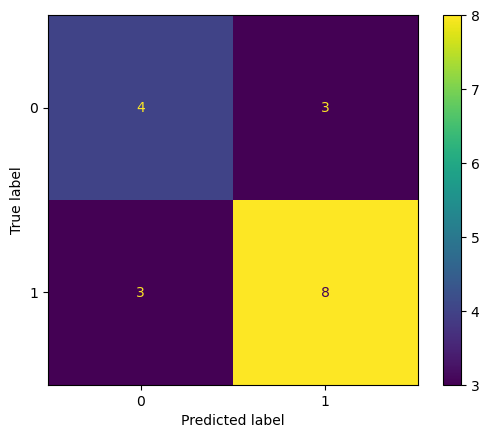

In [284]:
# Create the confusion matrix
cm = confusion_matrix(val_y_ai, y_pred_ai)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is fairly confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [285]:
accuracy = accuracy_score(val_y_ai, y_pred_ai)
precision = precision_score(val_y_ai, y_pred_ai)
recall = recall_score(val_y_ai, y_pred_ai)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6666666666666666
Precision: 0.7272727272727273
Recall: 0.7272727272727273


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

In this case, with 100% precision, means for all those that this model predict as depressed, it is precisely all of them really are depressed. But with low recall meaning our model is missing (in this case 42%) other patients who are depressed but failed to be detected by our model.

### Classification Report

In [286]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y_ai, y_pred_ai, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.57      0.57      0.57         7
   with PPTSD       0.73      0.73      0.73        11

     accuracy                           0.67        18
    macro avg       0.65      0.65      0.65        18
 weighted avg       0.67      0.67      0.67        18



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

## Saving The Model

## Load The Model

---